In [1]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:,.3f}'.format

### 동종업계 평균 수익률보다 더 좋은 수익률을 보여준다.     

In [2]:
mdl_data = pd.read_pickle('mdl_data.pkl')
mdl_data.head().style.set_table_attributes('style="font-size: 12px"').format(precision=3)

<br> 우선 과거 60일 평균 수익율 값을 return_mean 에 저장합니다. 그리고 종목에 sector 정보를 추가합니다.

In [3]:
kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

data_h6 = pd.DataFrame()

for code, sector in zip(kosdaq_list['code'], kosdaq_list['sector']):
    
    # 종목별 처리
    data = mdl_data[mdl_data['code']==code].sort_index().copy()
    data.dropna(inplace=True)
    
    # 최근 60일 평균 수익율            
    data['return_mean'] = data['return'].rolling(60).mean() # 종목별 최근 60 일 수익율의 평균
    data['sector'] = sector  # 섹터 정보   
  
    data.dropna(subset=['return_mean'], inplace=True)    
    data_h6 = pd.concat([data, data_h6], axis=0)

    
data_h6['sector_return'] = data_h6.groupby(['sector', data_h6.index])['return'].transform(lambda x: x.mean()) # 섹터와 날짜별 평균 값
data_h6['return over sector'] = (data_h6['return']/data_h6['sector_return'])

data_h6.to_pickle('data_h6.pkl')  

<br> 종목이 몇 개 없는 섹터는 평균의 의미가 없으므로 섹터에 종목이 최소한 10 개 이상이 있는 섹터만 보겠습니다. 

In [5]:
data_h6 = pd.read_pickle('data_h6.pkl')  
sector_count = data_h6.groupby('sector')['code'].nunique().sort_values() # 섹터 별로 종목 수 계산
data_h6x = data_h6[data_h6['sector'].isin(sector_count[sector_count>=10].index)].copy() # 섹터 별로 10개 이상이 있는 종목이 있는 섹터만 추출

<br> 섹터 평균 수익율 대비 종목 수익율이 아주 낮거나, 높은 경우에 미래 수익률이 높게 나왔습니다. 종목 수익률이 섹터 평균 수익률과 비슷한 경우('return over sector' 값이 1 근처인 경우)는 예상 수익율이 낮게 나타나고 있습니다.

                        count  mean   std   min   10%   50%   90%   max
return over sector                                                     
(0.688, 0.973]     26,887.000 1.042 0.087 0.700 0.974 1.022 1.126 2.968
(0.973, 0.983]     26,886.000 1.034 0.067 0.702 0.982 1.019 1.099 2.171
(0.983, 0.989]     26,886.000 1.030 0.060 0.704 0.984 1.016 1.087 2.286
(0.989, 0.994]     26,886.000 1.028 0.060 0.700 0.985 1.014 1.083 2.194
(0.994, 0.998]     26,889.000 1.027 0.058 0.819 0.985 1.013 1.080 2.729
(0.998, 1.002]     26,883.000 1.026 0.059 0.700 0.985 1.012 1.078 2.652
(1.002, 1.007]     26,886.000 1.027 0.062 0.700 0.984 1.012 1.080 3.027
(1.007, 1.014]     26,886.000 1.028 0.062 0.700 0.983 1.013 1.084 3.380
(1.014, 1.027]     26,886.000 1.031 0.068 0.700 0.980 1.014 1.093 2.412
(1.027, 1.399]     26,887.000 1.043 0.105 0.700 0.970 1.019 1.136 3.703


<AxesSubplot:xlabel='return over sector'>

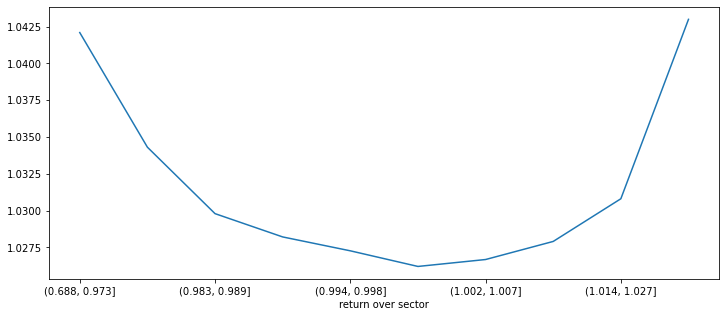

In [6]:
data_h6x['sector_return'] = data_h6x.groupby(['sector', data_h6x.index])['return'].transform(lambda x: x.mean())
data_h6x['return over sector'] = (data_h6x['return']/data_h6x['sector_return'])
ranks = pd.qcut(data_h6x['return over sector'], q=10)
print(data_h6x.groupby(ranks)['max_close'].describe(percentiles=[0.1, 0.9]))
data_h6x.groupby(ranks)['max_close'].mean().plot(figsize=(12,5))